In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import json
from pprint import pprint
import collections

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import ipywidgets as widgets
from matplotlib import gridspec
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from scipy.signal import resample_poly, butter, filtfilt, firwin, lfilter, find_peaks
# from tqdm import tqdm

project_root = '..'
sys.path.append(project_root)

from sleeprnn.data.loader import load_dataset
from sleeprnn.helpers.reader import RefactorUnpickler
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.detection import metrics
from sleeprnn.detection.postprocessor import PostProcessor
from sleeprnn.common import constants, pkeys, viz
from sleeprnn.detection import postprocessing

SEED_LIST = [123, 234, 345, 456]
RESULTS_PATH = os.path.join(project_root, 'results')
COMPARISON_PATH = os.path.join(project_root, 'resources', 'comparison_data')
DPI = 200
CUSTOM_COLOR = {'red': '#c62828', 'grey': '#455a64', 'blue': '#0277bd', 'green': '#43a047', 'cyan': '#00838F'} 
GREY_COLORS = {
    0: '#fafafa', 
    1: '#f5f5f5',
    2: '#eeeeee',
    3: '#e0e0e0',
    4: '#bdbdbd',
    5: '#9e9e9e',
    6: '#757575',
    7: '#616161',
    8: '#424242',
    9: '#212121',
}

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
def set_axis_color(ax, color):
    ax.spines['bottom'].set_color(color)
    ax.spines['top'].set_color(color) 
    ax.spines['right'].set_color(color)
    ax.spines['left'].set_color(color)
    ax.tick_params(axis='x', colors=color)
    ax.tick_params(axis='y', colors=color)
    ax.yaxis.label.set_color(color)
    ax.xaxis.label.set_color(color)
    ax.title.set_color(color)
    return ax

In [3]:
optimal_thr_for_ckpt_dict = {
    os.path.join('20190504_bsf_wn_train_mass_ss', 'bsf'): [0.64, 0.52, 0.52, 0.48],
    os.path.join('20190504_bsf_wn_train_mass_kc', 'bsf'): [0.52, 0.56, 0.54, 0.56],
    os.path.join('20190506_bsf_n2_train_mass_ss', 'bsf'): [0.52, 0.46, 0.50, 0.50],
    os.path.join('20190506_bsf_n2_train_mass_kc', 'bsf'): [0.52, 0.52, 0.56, 0.46],
    os.path.join('20190516_bsf_n2_train_inta_ss', 'bsf'): [0.48, 0.52, 0.48, 0.44],
    os.path.join('20190516_bsf_v2_n2_train_inta_ss', 'bsf'): [0.46, 0.52, 0.50, 0.46],
    os.path.join('20190522_bsf_newer_wins_fix_n2_train_inta_ss', 'bsf'): [0.44, 0.5, 0.44, 0.42],
    os.path.join('20190522_bsf_e1_n2_train_mass_ss', 'bsf'): [0.44, 0.56, 0.48, 0.48],
    os.path.join('20190522_bsf_e2_n2_train_mass_ss', 'bsf'): [0.6, 0.44, 0.36, 0.56],
    os.path.join('20190525_bsf_ch3_n2_train_inta_ss', 'bsf'): [0.48, 0.56, 0.52, 0.5],
    os.path.join('20190525_bsf_v4_n2_train_mass_ss', 'bsf_1'): [0.46, 0.4, 0.5, 0.46],
    os.path.join('20190527_bsf_v7_k3_n2_train_mass_ss', 'bsf_2'): [0.52, 0.44, 0.48, 0.42],
    os.path.join('20190530_bsf_v10_n2_train_mass_ss', 'bsf'): [0.6, 0.44, 0.56, 0.42],
    os.path.join('20190601_bsf_v11_n2_train_mass_ss', 'filters_32_64_128'): [0.64, 0.36, 0.58, 0.4],
    os.path.join('20190601_bsf_v11_n2_train_mass_ss', 'filters_64_128_256'): [0.62, 0.6, 0.52, 0.44],
    os.path.join('20190603_grid_cwt_fb05_n2_train_mass_ss', 'v12_f_32_64'): [0.66, 0.46, 0.52, 0.46],
    os.path.join('20190605_grid_v15_v16_n2_train_mass_ss', 'v15_timef_64_128_256_cwtf_32_32_fb_0.5'): [0.46, 0.52, 0.62, 0.42],
    os.path.join('20190614_bsf_global_std_n2_train_mass_ss', 'bsf'): [0.62, 0.4, 0.4, 0.48],
    os.path.join('20190617_grid_normalization_n2_train_mass_ss', 'norm_global'): [0.58, 0.42, 0.4, 0.5],
    os.path.join('20190608_bsf_ablation_n2_train_inta_ss', 'v15_tf_64-128-256_cwtf_32-32/rep0'): [0.48, 0.52, 0.5, 0.5],
    os.path.join('20190620_11_12_17_from_scratch_n2_train_dreams_ss', 'v11_None'): [0.22, 0.48, 0.28, 0.38],
    os.path.join('20190620_11_12_17_from_scratch_n2_train_dreams_ss', 'v12_True'): [0.36, 0.5, 0.34, 0.36],
    os.path.join('20190620_11_12_17_from_scratch_n2_train_dreams_ss', 'v17_True'): [0.34, 0.38, 0.28, 0.44],
    os.path.join('20190620_11_12_17_from_scratch_wn_train_dreams_ss', 'v11_None'): [0.36, 0.46, 0.4, 0.36],
    os.path.join('20190620_11_12_17_from_scratch_wn_train_dreams_ss', 'v12_True'): [0.48, 0.46, 0.46, 0.52],
    os.path.join('20190620_11_12_17_from_scratch_wn_train_dreams_ss', 'v17_True'): [0.3, 0.52, 0.28, 0.46],
    os.path.join('20190704_inta_meeting_n2_train_mass_ss', 'v15'): [0.5, 0.42, 0.56, 0.58],
    os.path.join('20190704_inta_meeting_n2_train_mass_ss', 'v20_indep'): [0.4, 0.62, 0.64, 0.56],
    os.path.join('20190704_inta_meeting_n2_train_inta_ss', 'v15'): [0.48, 0.48, 0.5, 0.46],
    os.path.join('20190704_inta_meeting_n2_train_inta_ss', 'v20_indep'): [0.54, 0.42, 0.5, 0.5],
    os.path.join('20190706_inta_05_n2_train_inta_ss', 'v15'): [0.42, 0.44, 0.48, 0.5],
    os.path.join('20190708_grid_v19_pte2_n2_train_mass_ss', 'r_1_i_1_m_1_p_0_fb_0.5'): [0.42, 0.58, 0.62, 0.54],
    os.path.join('20190825_v22_grid_n2_train_mass_ss', 'r_1_i_1_m_1_p_0_drop_0.3_f_64'): [0.52, 0.48, 0.5, 0.52],
    os.path.join('20190827_thesis_1_bsf_e1_n2_train_mass_ss', 'v19'): [0.54, 0.52, 0.64, 0.54],
    os.path.join('20190827_thesis_1_bsf_e2_n2_train_mass_ss', 'v19'): [0.58, 0.5, 0.34, 0.6],
    os.path.join('20190827_thesis_1_bsf_e1_n2_train_mass_kc', 'v19'): [0.54, 0.64, 0.52, 0.5],
    os.path.join('20190827_thesis_1_bsf_e1_n2_train_inta_ss', 'v19'): [0.42, 0.42, 0.46, 0.44],
    os.path.join('20190915_balancing_drop_n2_train_mass_ss', 'v11'): [0.5, 0.5, 0.5, 0.5],
    os.path.join('20190915_balancing_drop_n2_train_mass_ss', 'v19'): [0.5, 0.5, 0.5, 0.5],
    os.path.join('20190915_balancing_drop_n2_train_mass_kc', 'v11'): [0.5, 0.5, 0.5, 0.5],
    os.path.join('20190915_balancing_drop_n2_train_mass_kc', 'v19'): [0.5, 0.5, 0.5, 0.5],
    os.path.join('20190916_balancing_drop_v2_n2_train_mass_ss', 'v11'): [0.5, 0.5, 0.5, 0.5],
    os.path.join('20190916_balancing_drop_v2_n2_train_mass_ss', 'v19'): [0.5, 0.5, 0.5, 0.5],
    os.path.join('20190916_balancing_weight_n2_train_mass_ss', 'v11'): [0.5, 0.5, 0.5, 0.5],
    os.path.join('20190916_balancing_weight_n2_train_mass_ss', 'v19'): [0.5, 0.5, 0.5, 0.5],
    os.path.join('20190917_out_proba_init_grid_n2_train_mass_ss', 'p_0.01_lr_0.0001'): [0.44, 0.54, 0.56, 0.32],
    os.path.join('20190917_out_proba_init_grid_n2_train_mass_ss', 'p_0.1_lr_0.0001'): [0.24, 0.42, 0.54, 0.48],
    os.path.join('20190917_out_proba_init_equal_n2_train_mass_ss', 'v11'): [0.28, 0.58, 0.56, 0.4],
    os.path.join('20190927_out_proba_cwt_grid_n2_train_mass_ss', 'p_0.5_lr_0.0001'): [0.36, 0.42, 0.62, 0.4],
    os.path.join('20190927_out_proba_cwt_grid_n2_train_mass_ss', 'p_0.01_lr_0.0001'): [0.42, 0.46, 0.54, 0.36],
    os.path.join('20191003_loss_grid_cwt_n2_train_mass_ss', 'v19_p_0.5_focal_loss_gamma_1.0'): [0.42, 0.60, 0.58, 0.44],
    os.path.join('20191003_loss_grid_cwt_n2_train_mass_ss', 'v19_p_0.5_focal_loss_gamma_1.5'): [0.44, 0.50, 0.52, 0.52],
    os.path.join('20191003_loss_grid_cwt_n2_train_mass_ss', 'v19_p_0.5_focal_loss_gamma_2.0'): [0.44, 0.52, 0.54, 0.50],
    os.path.join('20191009_focal_loss_grid_n2_train_mass_ss', 'v19_p_0.5_focal_loss_gamma_2.5'): [0.46, 0.54, 0.54, 0.52],
    os.path.join('20191009_focal_loss_grid_n2_train_mass_ss', 'v19_p_0.5_focal_loss_gamma_3.0'): [0.46, 0.52, 0.50, 0.46],
    os.path.join('20191009_focal_loss_grid_n2_train_mass_ss', 'v19_p_0.5_focal_loss_gamma_3.5'): [0.44, 0.54, 0.50, 0.50],
    os.path.join('20191009_focal_loss_grid_n2_train_mass_ss', 'v19_p_0.5_focal_loss_gamma_4.0'): [0.46, 0.52, 0.52, 0.50],
    os.path.join('20190927_loss_grid_n2_train_mass_ss', 'v11_p_0.5_dice_loss_gamma_None'): [0.50, 0.50, 0.50, 0.50],
    os.path.join('20190927_loss_grid_n2_train_mass_ss', 'v11_p_0.5_focal_loss_gamma_1.0'): [0.48, 0.50, 0.54, 0.50],
    os.path.join('20190927_loss_grid_n2_train_mass_ss', 'v11_p_0.5_focal_loss_gamma_1.5'): [0.42, 0.50, 0.56, 0.44],
    os.path.join('20190927_loss_grid_n2_train_mass_ss', 'v11_p_0.5_focal_loss_gamma_2.0'): [0.46, 0.54, 0.54, 0.46],
    os.path.join('20191009_focal_loss_grid_n2_train_mass_ss', 'v11_p_0.5_focal_loss_gamma_2.5'): [0.44, 0.52, 0.46, 0.44],
    os.path.join('20191009_focal_loss_grid_n2_train_mass_ss', 'v11_p_0.5_focal_loss_gamma_3.0'): [0.48, 0.54, 0.54, 0.50],
    os.path.join('20191009_focal_loss_grid_n2_train_mass_ss', 'v11_p_0.5_focal_loss_gamma_3.5'): [0.48, 0.52, 0.52, 0.50],
    os.path.join('20191009_focal_loss_grid_n2_train_mass_ss', 'v11_p_0.5_focal_loss_gamma_4.0'): [0.46, 0.48, 0.52, 0.48],
    os.path.join('20191013_train_at_128Hz_n2_train_mass_ss', 'v19'): [0.26, 0.54, 0.68, 0.34],
    os.path.join('20191017_elastic_grid_pte2_n2_train_mass_ss', 'v11_alpha_0.25_sigma_0.125_keepbest_True'): [0.54, 0.40, 0.42, 0.48],
    os.path.join('20191017_elastic_grid_pte2_n2_train_mass_ss', 'v11_alpha_0.15_sigma_0.075_keepbest_True'): [0.50, 0.34, 0.36, 0.48],
    os.path.join('20191017_elastic_grid_pte2_n2_train_mass_ss', 'v11_alpha_0.25_sigma_0.100_keepbest_False'): [0.36, 0.48, 0.52, 0.48],
    os.path.join('20191106_forced_sep_n2_train_mass_kc', 'v11_sep_0.10'): [0.62, 0.54, 0.54, 0.44],
    os.path.join('20191106_forced_sep_n2_train_mass_kc', 'v11_sep_0.15'): [0.46, 0.52, 0.52, 0.50],
    os.path.join('20191106_forced_sep_n2_train_mass_kc', 'v11_sep_0.00'): [0.60, 0.50, 0.58, 0.52],
    os.path.join('20191106_forced_sep_n2_train_mass_kc', 'v11_sep_0.20'): [0.50, 0.52, 0.54, 0.52],
}

In [4]:
ckpt_folder = os.path.join('20190827_thesis_1_bsf_e1_n2_train_mass_kc', 'v19')
ckpt_fs = 200
load_dataset_from_ckpt = True
which_expert = 1

iou_hist_bins = np.linspace(0, 1, 21)

new_split_version = True
optimal_thr_list = optimal_thr_for_ckpt_dict[ckpt_folder]
task_mode = constants.N2_RECORD
dataset_name = constants.MASS_KC_NAME
seed_id_list = [0, 1, 2, 3]
# seed_id_list = [1]

n_seeds = len(seed_id_list)
set_list = [constants.TRAIN_SUBSET, constants.VAL_SUBSET, constants.TEST_SUBSET]
# set_list = [constants.TEST_SUBSET]
verbose = False

# Load data
dataset = load_dataset(
    dataset_name, load_checkpoint=load_dataset_from_ckpt, 
    params={pkeys.NORM_COMPUTATION_MODE: constants.NORM_GLOBAL, pkeys.FS: ckpt_fs})
fs = dataset.fs
all_train_ids = dataset.train_ids
test_ids = dataset.test_ids
predictions_dict = {}
for k in seed_id_list:
    # Restore predictions
    ckpt_path = os.path.abspath(os.path.join(
        RESULTS_PATH,
        'predictions_%s' % dataset_name,
        ckpt_folder,
        'seed%d' % k
    ))
    this_dict = {}
    for set_name in set_list:
        filename = os.path.join(
                ckpt_path,
                'prediction_%s_%s.pkl' % (task_mode, set_name))
        with open(filename, 'rb') as handle:
            this_pred = RefactorUnpickler(handle).load()
        this_dict[set_name] = this_pred
    predictions_dict[k] = this_dict
    print('Loaded seed %d/%d from %s' % (k + 1, n_seeds, ckpt_path))
print('Optimal thr:', optimal_thr_list)

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_kc with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042
Loaded seed 1/4 from /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_kc/20190827_thesis_1_bsf_e1_n2_train_mass_kc/v19/seed0
Loaded seed 2/4 from /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_kc/20190827_thesis_1_bsf_e1_n2_train_mass_kc/v19/seed1
Loaded seed 3/4 from /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_kc/20190827_thesis_1_bsf_e1_n2_train_mass_kc/v19/seed2
Loaded seed 4/4 from /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_kc/20190827_thesis_1_bsf_e1_n2_train_mass_kc/v19/seed3
Optimal thr: [0.54, 0.64, 0.52, 0.5]


In [7]:
# optional postprocessing

postprocess = True

    
# ---------------- Compute performance
f1_vs_iou_dict = {}
first_iou = 0.05
last_iou = 0.95
step_iou = 0.05
n_points = int(np.round((last_iou - first_iou) / step_iou))
iou_list = first_iou + np.arange(n_points + 1) * step_iou
iou_list_short = np.arange(1, 10) * 0.1
iou_list_short_idx = [np.where(np.isclose(iou_list, this_value))[0][0] for this_value in iou_list_short]

# Prepare expert labels
data_test = FeederDataset(
    dataset, test_ids, task_mode, which_expert=which_expert)
this_events = data_test.get_stamps()
this_signals = data_test.get_signals()

seed_stamps = []
test_af1_list = []
seed_mean_ioutp = []
model_iou_hist_list = []
for k in seed_id_list:
    # Prepare model predictions
    prediction_test = predictions_dict[k][constants.TEST_SUBSET]
    
    prediction_test.set_probability_threshold(optimal_thr_list[k])
    this_detections = prediction_test.get_stamps()
    
    if postprocess and dataset_name == constants.MASS_KC_NAME:
        new_detections = []
        print('Postprocessing')
        for single_detection, single_signal in zip(this_detections, this_signals):
            single_detection = postprocessing.kcomplex_stamp_split(single_signal, single_detection, fs)
            new_detections.append(single_detection)
        this_detections = new_detections
    
    seed_stamps.append(this_detections)
    this_f1_vs_iou = metrics.metric_vs_iou_with_list(
        this_events, this_detections, iou_list)
    this_af1 = metrics.average_metric_with_list(this_events, this_detections)
    f1_vs_iou_dict[k] = this_f1_vs_iou
    test_af1_list.append(this_af1)
    
    # Measure iou of TP
    mean_iou_per_subject = []
    iou_hist_seed = []
    for single_events, single_detections in zip(this_events, this_detections):
        this_iou_array, idx_array = metrics.matching(single_events, single_detections)
        this_iou_array = this_iou_array[idx_array > -1]
        iou_hist, _ = np.histogram(this_iou_array, bins=iou_hist_bins, density=True)
        mean_iou_per_subject.append(np.mean(this_iou_array))
        iou_hist_seed.append(iou_hist)
    seed_mean_ioutp.append(np.mean(mean_iou_per_subject))
    iou_hist_seed = np.stack(iou_hist_seed, axis=0).mean(axis=0)
    model_iou_hist_list.append(iou_hist_seed)
    
# Mean performance
mean_f1_vs_iou = np.stack([f1_vs_iou_dict[k] for k in seed_id_list], axis=1).mean(axis=1)
std_f1_vs_iou = np.stack([f1_vs_iou_dict[k] for k in seed_id_list], axis=1).std(axis=1)
mean_f1_vs_iou_short = mean_f1_vs_iou[iou_list_short_idx]
std_f1_vs_iou_short = std_f1_vs_iou[iou_list_short_idx]

print('IoU   Mean    Std')
for k in range(iou_list_short.size):
    print('%1.2f  %1.4f  %1.4f' % (iou_list_short[k], mean_f1_vs_iou_short[k], std_f1_vs_iou_short[k]))
    
print('Test AF1: %1.4f +- %1.4f' % (np.mean(test_af1_list), np.std(test_af1_list)))
print('Test AF1 per seed:', test_af1_list)
print('Test Mean IoU at TP: %1.4f +- %1.4f' % (np.mean(seed_mean_ioutp), np.std(seed_mean_ioutp)))

Normalizing with Global STD of 16.482042
Normalizing with Global STD of 16.482042
Normalizing with Global STD of 16.482042
Normalizing with Global STD of 16.482042
Postprocessing
Postprocessing
Postprocessing
Postprocessing
IoU   Mean    Std
0.10  0.8275  0.0042
0.20  0.8260  0.0047
0.30  0.8248  0.0044
0.40  0.8242  0.0045
0.50  0.8224  0.0042
0.60  0.8161  0.0042
0.70  0.7975  0.0054
0.80  0.7470  0.0050
0.90  0.5717  0.0111
Test AF1: 0.7486 +- 0.0042
Test AF1 per seed: [0.7437689099368562, 0.7509923031206843, 0.7541610082012891, 0.7454980828652406]
Test Mean IoU at TP: 0.9039 +- 0.0018


Normalizing with Global STD of 16.482042
Postprocessing KC marks
UFN: 81
UFP 203
Matched 776 776
F1 at IoU>0 0.85


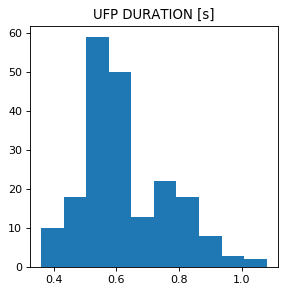

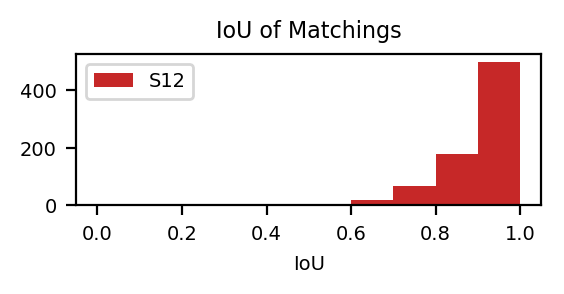

In [17]:
postprocess = True

seed_to_show = 0
set_name = 'test'
subject_id = 12
center_on_real = False
iou_range = [0, 0.3]
duration_range = [0, 5]
show_hypno = True


band_pass_freqs = [12, 14]

# -----
if dataset_name in [constants.MASS_SS_NAME, constants.MASS_KC_NAME]:
    channel_name = 'C3-CLE'
elif dataset_name in [constants.DREAMS_SS_NAME, constants.DREAMS_KC_NAME]:
    channel_name = 'Cz-A1'
else:
    channel_name = 'F4-C4'


pages_subset = constants.N2_RECORD

if new_split_version:
    train_ids, val_ids = utils.split_ids_list_v2(
        all_train_ids, split_id=seed_to_show)
else:
    train_ids, val_ids = utils.split_ids_list(
        all_train_ids, seed=SEED_LIST[seed_to_show])

idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids, 'alltrain': all_train_ids}
idx_subject = idx_dict[set_name].index(subject_id)

this_pages = dataset.get_subject_pages(subject_id=subject_id, pages_subset=pages_subset)
if show_hypno:
    this_hypnogram = dataset.get_subject_hypnogram(subject_id=subject_id)
this_signal = dataset.get_subject_signal(subject_id=subject_id, normalization_mode=task_mode, which_expert=which_expert)
this_stamps = dataset.get_subject_stamps(subject_id=subject_id, pages_subset=pages_subset, which_expert=which_expert)
this_stamps_full = this_stamps.copy()
if (subject_id not in [4, 8, 15, 16]) and dataset_name == constants.MASS_SS_NAME:
    this_stamps_2 = dataset.get_subject_stamps(subject_id=subject_id, pages_subset=pages_subset, which_expert=2)
    this_stamps_2_full = this_stamps_2.copy()
else:
    this_stamps_2 = None
    this_stamps_2_full = None

event_name = dataset.event_name

this_thr = optimal_thr_list[seed_to_show]
prediction_set = predictions_dict[seed_to_show][set_name]
prediction_set.set_probability_threshold(this_thr)

this_predicted_stamps = prediction_set.get_subject_stamps(subject_id=subject_id, pages_subset=constants.WN_RECORD)
if postprocess and dataset_name == constants.MASS_KC_NAME:
    print('Postprocessing KC marks')
    this_predicted_stamps = postprocessing.kcomplex_stamp_split(this_signal, this_predicted_stamps, fs)

this_predicted_stamps_full = this_predicted_stamps.copy()

this_proba = prediction_set.get_subject_probabilities(subject_id=subject_id)

fs_real = dataset.fs
down_factor = prediction_set.params[pkeys.TOTAL_DOWNSAMPLING_FACTOR]
fs_proba = fs_real / down_factor

# make a color map of fixed colors
cmap = colors.ListedColormap(['white', '#c62828'])

# Matching:
this_iou_array, this_idx_array = metrics.matching(this_stamps, this_predicted_stamps)
this_expert_iou = this_iou_array
n_detections = this_predicted_stamps.shape[0]
this_dectection_iou = np.zeros(n_detections)

for i in range(n_detections):
    if i in this_idx_array:
        matching_idx = np.where(this_idx_array == i)[0][0]
        this_dectection_iou[i] = this_iou_array[matching_idx]        

# Number of missed reals:
n_ufn = np.sum(this_expert_iou == 0)
# Number of false detections:
n_ufp = np.sum(this_dectection_iou == 0)
# Number of matched pairs
n_matched = np.sum(this_expert_iou > 0)
n_matched_v2 = np.sum(this_dectection_iou > 0)
print('UFN:', n_ufn)
print('UFP', n_ufp)
print('Matched', n_matched, n_matched_v2)
precision = n_matched / (n_matched + n_ufp)
recall = n_matched / (n_matched + n_ufn)
f1_at_iou0 = 2 * precision * recall / (precision + recall)
print('F1 at IoU>0 %1.2f' % f1_at_iou0)

# histogram of UFP durations
ufp_idx = np.where(this_dectection_iou == 0)[0]
ufp_det = this_predicted_stamps[ufp_idx]
ufp_dur = (ufp_det[:, 1] - ufp_det[:, 0])/fs
fig = plt.figure(figsize=(4, 4), dpi=80)
plt.hist(ufp_dur)
plt.title('UFP DURATION [s]')
plt.show()

# Fraction of UFP that does not match E1 but match E2
if this_stamps_2_full is not None:
    print('** UFP and E2 intersection analysis ** ')
    all_ufp = this_predicted_stamps_full[this_dectection_iou == 0]
    overlap_ufp_e1 = utils.get_overlap_matrix(all_ufp, this_stamps_full)
    valid_ufp = np.where(overlap_ufp_e1.sum(axis=1) == 0)[0]
    print('UFP removed because E1 intersection: %d' % (all_ufp.shape[0] - valid_ufp.size))
    all_ufp = all_ufp[valid_ufp]
    overlap_ufp_e2 = utils.get_overlap_matrix(all_ufp, this_stamps_2_full)
    idx_with_e2_intersection = np.where(overlap_ufp_e2.sum(axis=1) > 0)[0]
    print('UFP with intersection with E2 and none with E1: %d (%1.2f %%)' % (
        idx_with_e2_intersection.size, 100*idx_with_e2_intersection.size/n_ufp))


fig, ax = plt.subplots(1, 1, figsize=(3, 1), dpi=200)
ax.hist(this_expert_iou[this_expert_iou > 0], bins=[0.1*i for i in range(11)], color=CUSTOM_COLOR['red'], label='S%02d' % subject_id)
ax.legend(loc='upper left', fontsize=7)
ax.set_title('IoU of Matchings', fontsize=8)
ax.set_xticks([0.1*i for i in range(0, 11, 2)])
ax.set_xlabel('IoU', fontsize=7)
ax.tick_params(labelsize=7)
plt.show()
        
# filter
if center_on_real:
    idx_useful_iou = np.where( (this_expert_iou >= iou_range[0]) & (this_expert_iou <= iou_range[1]) )[0]
    duration_expert = (this_stamps[:, 1] - this_stamps[:, 0]) / fs_real
    idx_useful_duration = np.where( (duration_expert >= duration_range[0]) & (duration_expert <= duration_range[1]) )[0]
    idx_useful = [i for i in idx_useful_iou if i in idx_useful_duration]
    this_stamps = this_stamps[idx_useful]
    this_expert_iou = this_expert_iou[idx_useful]
else:
    idx_useful_iou = np.where( (this_dectection_iou >= iou_range[0]) & (this_dectection_iou <= iou_range[1]) )[0]
    duration_det = (this_predicted_stamps[:, 1] - this_predicted_stamps[:, 0]) / fs_real
    idx_useful_duration = np.where( (duration_det >= duration_range[0]) & (duration_det <= duration_range[1]) )[0]
    idx_useful = [i for i in idx_useful_iou if i in idx_useful_duration]
    this_predicted_stamps = this_predicted_stamps[idx_useful]
    this_dectection_iou = this_dectection_iou[idx_useful]

def filter_stamps(stamps, start_sample, end_sample):
    pages_list = []
    for i in range(stamps.shape[0]):
        start_inside = (stamps[i, 0] > start_sample) and (stamps[i, 0] < end_sample)
        end_inside = (stamps[i, 1] > start_sample) and (stamps[i, 1] < end_sample)

        if start_inside or end_inside:
            pages_list.append(stamps[i, :])
    return pages_list


def plot_event(event_idx):

    if this_stamps_2 is None:
        fig = plt.figure(figsize=(12, 4), dpi=DPI)
        gs = gridspec.GridSpec(3, 1, height_ratios=[4, 2, 1])
    else:
        fig = plt.figure(figsize=(12, 5), dpi=DPI)
        gs = gridspec.GridSpec(4, 1, height_ratios=[4, 2, 1, 1])
    
    event_idx = event_idx - 1
    
    if center_on_real:
        event_chosen = this_stamps[event_idx, :]
        iou_chosen = this_expert_iou[event_idx]
    else:
        event_chosen = this_predicted_stamps[event_idx, :]
        iou_chosen = this_dectection_iou[event_idx]

    start_sample = int(event_chosen[0] - 10 * fs_real)
    end_sample = int(event_chosen[1] + 10 * fs_real)

    page_of_center = int(((end_sample + start_sample) / 2) / dataset.page_size)
    if show_hypno:
        page_state = this_hypnogram[page_of_center]
    else:
        page_state = '?'
    
    segment_signal = this_signal[start_sample:end_sample]
    segment_stamps = filter_stamps(this_stamps_full, start_sample, end_sample)
    if this_stamps_2 is not None:
        segment_stamps_2 = filter_stamps(this_stamps_2_full, start_sample, end_sample)
    segment_proba = this_proba[int(start_sample/down_factor):int(end_sample/down_factor)]
    segment_predicted_stamps = filter_stamps(this_predicted_stamps_full, start_sample, end_sample)
    
    time_axis_real = np.arange(start_sample, end_sample) / fs_real
    time_axis_proba = np.arange(int(start_sample/down_factor), int(end_sample/down_factor)) / fs_proba
    
    gs_idx = 0
    
    # Signal
    y_max = 10
    ax = fig.add_subplot(gs[gs_idx])
    gs_idx = gs_idx + 1
    ax.plot(
        time_axis_real, segment_signal, 
        linewidth=1, color=CUSTOM_COLOR['grey'], label='EEG %s' % channel_name)
    stamp_label_used = False
    for expert_stamp in segment_stamps:
        if stamp_label_used:
            label = None
        else:
            label = event_name
            stamp_label_used = True
        ax.fill_between(
            expert_stamp / fs_real, y_max, -y_max, 
            facecolor=CUSTOM_COLOR['blue'], alpha=0.3, label=label,
            edgecolor='k', linewidth=1.5, 
        )
    ax.set_yticks([])
    ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
    ax.set_ylim([-y_max, y_max])
    if center_on_real:
        ax.set_title('Subject %d (%s-%s). Expert mark idx: %d. IoU %1.2f. State %s (intervals of 0.5s are shown).' 
                     % (subject_id, dataset_name.upper(), set_name.capitalize(), event_idx, iou_chosen, page_state), fontsize=10)
    else:
        ax.set_title('Subject %d (%s-%s). Detection idx: %d. IoU %1.2f. State %s (intervals of 0.5s are shown).' 
                     % (subject_id, dataset_name.upper(), set_name.capitalize(), event_idx, iou_chosen, page_state), fontsize=10)
        
    ax.set_xticks([
        time_axis_real[0], 
        time_axis_real[0] + 5, 
        time_axis_real[0] + 10, 
        time_axis_real[0] + 15, 
        time_axis_real[0] + 20])
    ax.set_yticks([0], minor=True)
    ax.grid(b=True, axis='y', which='minor')
    ax.set_xticks(np.arange(time_axis_real[0], time_axis_real[-1], 0.5), minor=True)
    ax.grid(b=True, axis='x', which='minor')
    lg = ax.legend(loc='upper right', fontsize=8.5)
    # lh = lg.legendHandles[1]
    # lh.set_facecolor(lh.get_facecolor())
    # lh.set_alpha(1.0)
    ax.tick_params(labelsize=8.5)
    
    # Band pass Signal
    y_max = 10
    ax = fig.add_subplot(gs[gs_idx])
    gs_idx = gs_idx + 1
    # segment_signal_filtered = utils.narrow_filter(segment_signal, fs_real, band_pass_freqs[0], band_pass_freqs[1])
    segment_signal_filtered = utils.filter_iir_lowpass(segment_signal, fs, highcut=4)
    #segment_signal_filtered = utils.filter_windowed_sinusoidal(segment_signal, fs_real, 13, 41)
    ax.plot(
        time_axis_real, segment_signal_filtered, 
        linewidth=1, color=CUSTOM_COLOR['grey'], label='EEG %s' % channel_name)
    stamp_label_used = False
    for expert_stamp in segment_stamps:
        if stamp_label_used:
            label = None
        else:
            label = event_name
            stamp_label_used = True
        ax.fill_between(
            expert_stamp / fs_real, y_max, -y_max, 
            facecolor=CUSTOM_COLOR['blue'], alpha=0.3, label=label,
            edgecolor='k', linewidth=1.5, 
        )
    ax.set_yticks([])
    ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
    ax.set_ylim([-y_max, y_max])
    ax.set_title('Bandpass filtered signal (sigma)', fontsize=10)
    ax.set_xticks([
        time_axis_real[0], 
        time_axis_real[0] + 5, 
        time_axis_real[0] + 10, 
        time_axis_real[0] + 15, 
        time_axis_real[0] + 20])
    ax.set_xticks(np.arange(time_axis_real[0], time_axis_real[-1], 0.5), minor=True)
    ax.grid(b=True, axis='x', which='minor')
    ax.set_yticks([0], minor=True)
    ax.grid(b=True, axis='y', which='minor')
    lg = ax.legend(loc='upper right', fontsize=8.5)
    # lh = lg.legendHandles[1]
    # lh.set_facecolor(lh.get_facecolor())
    # lh.set_alpha(1.0)
    ax.tick_params(labelsize=8.5)
    
    # Neural net
    delta_y = 0.1
    ax = fig.add_subplot(gs[gs_idx])
    gs_idx = gs_idx + 1
    ax.plot(
        time_axis_proba, segment_proba, 
        color=CUSTOM_COLOR['red'], linewidth=1.5, zorder=7)
    for model_stamp in segment_predicted_stamps:
        ax.fill_between(
            model_stamp / fs_real, 1+delta_y, -delta_y, 
            facecolor=CUSTOM_COLOR['red'], zorder=6, alpha=0.3,
            edgecolor='k', linewidth=1.5, 
        )
    ax.set_xticks([])
    ax.set_ylim([-delta_y, 1+delta_y])
    ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
    ax.set_yticks([0, 1])
    ax.set_yticks([this_thr], minor=True)
    ax.grid(b=True, axis='y', linewidth=1.5, which='minor', zorder=5)
    ax.tick_params(labelsize=8.5)
    ax.set_title('Model prediction: probability and postprocessed stamps (%1.2f threshold is shown)' % this_thr, fontsize=10)
    
    if this_stamps_2 is not None:
        ax = fig.add_subplot(gs[gs_idx])
        # ax.imshow(segment_marks_2[np.newaxis, :], interpolation=None, aspect='auto', cmap=cmap)
        for expert_stamp in segment_stamps_2:
            ax.fill_between(
                expert_stamp / fs_real, y_max, -y_max, 
                facecolor=CUSTOM_COLOR['blue'], alpha=0.3,
                edgecolor='k', linewidth=1.5, 
            )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylim([-delta_y, 1+delta_y])
        ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
        ax.set_title('Second expert stamps (not used for training)', fontsize=10)
    
    plt.tight_layout()
    plt.show()

In [18]:
print('Showing events with IoU in range %s' % iou_range)
print('Showing events with duration in range %s [s]' % duration_range)
if center_on_real:
    max_value = this_stamps.shape[0]
    print('Number of real events selected %d' % max_value)
else:
    max_value = this_predicted_stamps.shape[0]
    print('Number of detected events selected %d' % max_value)

widgets.interact(
    lambda event_idx: plot_event(event_idx),
    event_idx=widgets.IntSlider(min=1,max=max_value,step=1,value=3, continuous_update=False));

Showing events with IoU in range [0, 0.3]
Showing events with duration in range [0, 5] [s]
Number of detected events selected 205


interactive(children=(IntSlider(value=3, continuous_update=False, description='event_idx', max=205, min=1), Ou…

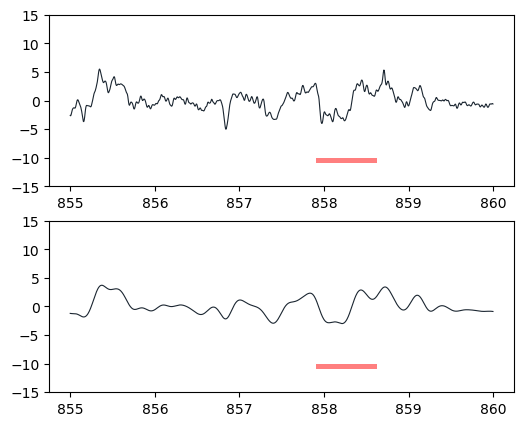

In [8]:
start_time = 855
end_time = 860

start_sample = int(start_time * fs)
end_sample = int(end_time * fs)
tmp_segment_signal = this_signal[start_sample:end_sample]
tmp_segment_det = utils.filter_stamps(this_predicted_stamps, start_sample, end_sample)
tmp_segment_real = utils.filter_stamps(this_stamps, start_sample, end_sample)
bandpass_signal = utils.filter_iir_lowpass(this_signal, fs)
tmp_segment_filt = bandpass_signal[start_sample:end_sample]

fig, ax = plt.subplots(2, 1, figsize=(6, 5), dpi=100)
time_axis = np.arange(start_sample, end_sample) / fs
displacement = 0.5
ax[0].plot(time_axis, tmp_segment_signal, linewidth=0.8, color=viz.PALETTE['dark'])
offset = 0
for i, stamp in enumerate(tmp_segment_det):
    offset = offset - i * displacement
    ax[0].fill_between(stamp/fs, offset-10, offset-11, facecolor='r', alpha=0.5)
offset = 0
for i, stamp in enumerate(tmp_segment_real):
    offset = offset - i * displacement
    ax[0].fill_between(stamp/fs, offset-12, offset-13, facecolor='b', alpha=0.5)
ax[0].set_ylim([-15, 15])

ax[1].plot(time_axis, tmp_segment_filt, linewidth=0.8, color=viz.PALETTE['dark'])
offset = 0
for i, stamp in enumerate(tmp_segment_det):
    offset = offset - i * displacement
    ax[1].fill_between(stamp/fs, offset-10, offset-11, facecolor='r', alpha=0.5)
ax[1].set_ylim([-15, 15])

plt.show()

In [9]:
stamp = np.array([tmp_segment_det[0, 0], tmp_segment_det[-1, 1]])
print(stamp/fs)

filt_in_stamp = bandpass_signal[stamp[0]:stamp[1]]
negative_peaks, _ = find_peaks(- filt_in_stamp)

# Change of sign filtering
group_peaks = [[negative_peaks[0]]]
idx_group = 0
for i in range(1, len(negative_peaks)):
    last_peak = group_peaks[idx_group][-1]
    this_peak = negative_peaks[i]
    signal_between_peaks = filt_in_stamp[last_peak:this_peak]
    min_value = signal_between_peaks.min()
    max_value = signal_between_peaks.max()
    if min_value < 0 and max_value > 0:
        # there is a change of sign, so it is a new group
        group_peaks.append([this_peak])
        idx_group = idx_group + 1
    else:
        # Now change of sign, same group
        group_peaks[idx_group].append(this_peak)
new_peaks = []
for single_group in group_peaks:
    new_peaks.append(int(np.mean(single_group)))
print(new_peaks)



[857.9  858.62]
[46, 134]


In [10]:
group_peaks

[[31, 62], [134]]

In [11]:
negative_peaks

array([ 31,  62, 134])

In [12]:
(tmp_segment_det[:, 1] - tmp_segment_det[:, 0])/fs

array([0.72])

In [13]:
# Matching:
this_iou_array, this_idx_array = metrics.matching(this_stamps, this_predicted_stamps)
this_expert_iou = this_iou_array
n_detections = this_predicted_stamps.shape[0]
this_dectection_iou = np.zeros(n_detections)

for i in range(n_detections):
    if i in this_idx_array:
        tmp_matched = np.where(this_idx_array == i)[0]
        if len(tmp_matched) > 1:
            print('Duplicated assignment')
            print(i)
            print(tmp_matched)
            print('Detection', this_predicted_stamps[i])
            print('Reals:')
            for single_idx in tmp_matched:
                print(this_stamps[single_idx])
            
        matching_idx = np.where(this_idx_array == i)[0][0]
        this_dectection_iou[i] = this_iou_array[matching_idx]        

# Number of missed reals:
n_ufn = np.sum(this_expert_iou == 0)
# Number of false detections:
n_ufp = np.sum(this_dectection_iou == 0)
# Number of matched pairs
n_matched = np.sum(this_expert_iou > 0)
n_matched_v2 = np.sum(this_dectection_iou > 0)
print('UFN:', n_ufn)
print('UFP', n_ufp)
print('Matched', n_matched, n_matched_v2)
precision = n_matched / (n_matched + n_ufp)
recall = n_matched / (n_matched + n_ufn)
f1_at_iou0 = 2 * precision * recall / (precision + recall)
print('F1 at IoU>0 %1.2f' % f1_at_iou0)

UFN: 0
UFP 895
Matched 42 42
F1 at IoU>0 0.09


In [14]:
postprocess = False

seed_to_show = 0
set_name = 'test'
subject_id = 12
center_on_real = True
iou_range = [0.01, 0.6]
duration_range = [0, 5]
show_hypno = True


band_pass_freqs = [12, 14]

# -----
if dataset_name in [constants.MASS_SS_NAME, constants.MASS_KC_NAME]:
    channel_name = 'C3-CLE'
elif dataset_name in [constants.DREAMS_SS_NAME, constants.DREAMS_KC_NAME]:
    channel_name = 'Cz-A1'
else:
    channel_name = 'F4-C4'


pages_subset = constants.N2_RECORD

if new_split_version:
    train_ids, val_ids = utils.split_ids_list_v2(
        all_train_ids, split_id=seed_to_show)
else:
    train_ids, val_ids = utils.split_ids_list(
        all_train_ids, seed=SEED_LIST[seed_to_show])

idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids, 'alltrain': all_train_ids}
idx_subject = idx_dict[set_name].index(subject_id)

this_pages = dataset.get_subject_pages(subject_id=subject_id, pages_subset=pages_subset)
if show_hypno:
    this_hypnogram = dataset.get_subject_hypnogram(subject_id=subject_id)
this_signal = dataset.get_subject_signal(subject_id=subject_id, normalization_mode=task_mode, which_expert=which_expert)
this_stamps = dataset.get_subject_stamps(subject_id=subject_id, pages_subset=pages_subset, which_expert=which_expert)
this_stamps_full = this_stamps.copy()
if (subject_id not in [4, 8, 15, 16]) and dataset_name == constants.MASS_SS_NAME:
    this_stamps_2 = dataset.get_subject_stamps(subject_id=subject_id, pages_subset=pages_subset, which_expert=2)
    this_stamps_2_full = this_stamps_2.copy()
else:
    this_stamps_2 = None
    this_stamps_2_full = None

event_name = dataset.event_name

this_thr = optimal_thr_list[seed_to_show]
prediction_set = predictions_dict[seed_to_show][set_name]
prediction_set.set_probability_threshold(this_thr)

this_predicted_stamps = prediction_set.get_subject_stamps(subject_id=subject_id, pages_subset=constants.WN_RECORD)
if postprocess and dataset_name == constants.MASS_KC_NAME:
    print('Postprocessing KC marks')
    this_predicted_stamps = postprocessing.kcomplex_stamp_split(this_signal, this_predicted_stamps, fs)

this_predicted_stamps_full = this_predicted_stamps.copy()

this_proba = prediction_set.get_subject_probabilities(subject_id=subject_id)

fs_real = dataset.fs
down_factor = prediction_set.params[pkeys.TOTAL_DOWNSAMPLING_FACTOR]
fs_proba = fs_real / down_factor

# make a color map of fixed colors
cmap = colors.ListedColormap(['white', '#c62828'])

Normalizing with Global STD of 16.482042
